In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import lightgbm as lgbm
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer
import seaborn as sns

### Loading the data

In [22]:
df = pd.read_csv('preprocessed_train_val.csv')
df = df.sample(frac = 1)

In [23]:
y = df['Weekly_Sales']
X = df.drop(['Weekly_Sales'],axis  =1)

In [24]:
X_test = pd.read_csv('preprocessed_test.csv')

### Baselines

#### define the metric

In [25]:
def wmae(X,y,y_pred):
    
    weight = X['IsHoliday'].apply(lambda x: 5 if x else 1)
    WMAE = sum(weight * abs(y - y_pred)) / sum(weight)
    
    return WMAE

In [26]:
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

#### RandomForest Regressor

In [7]:
# rf_regr = RandomForestRegressor(n_estimators = 100, max_depth=30, 
#                                 max_features = 7,min_samples_leaf = 2)
# rf_regr.fit(x_train,y_train)
# val_pred = rf_regr.predict(x_val)

# print(wmae(x_val,y_val,val_pred))

#### XGBoost regressor

In [8]:
# xgb_regr = xgb.XGBRegressor(objective='reg:squarederror',n_estimators = 400, 
#                             max_depth = 15, learning_rate = 0.35,random_state=7)
# xgb_regr.fit(x_train, y_train)
# xgb_pred = xgb_regr.predict(x_val)

# print(wmae(x_val,y_val,xgb_pred))

#### LightGBM regressor

In [9]:
# lgbm_regr = lgbm.LGBMRegressor(n_estimators = 100, n_jobs =-1, random_state=7)
# lgbm_regr.fit(x_train, y_train)
# lgbm_pred = lgbm_regr.predict(x_val)

# print(wmae(x_val,y_val,lgbm_pred))

#### K-fold crossvalidation

In [10]:
# kf = KFold(n_splits=5) 

In [11]:
# rf_wmae = []
# for train_index, val_index in kf.split(X):
#     X_train, X_val = X.iloc[train_index], X.iloc[val_index]
#     y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
#     rf_regr = RandomForestRegressor(n_estimators = 60, max_depth=30, max_features = 6)
#     rf_regr.fit(X_train,y_train)
#     val_pred = rf_regr.predict(X_val)
    
    
#     rf_wmae.append(wmae(X_val,y_val,val_pred))
    
# print(np.mean(rf_wmae))

In [12]:
# xgb_wmae = []
# for train_index, val_index in kf.split(X):
#     X_train, X_val = X.iloc[train_index], X.iloc[val_index]
#     y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
#     xgb_regr = xgb.XGBRegressor(objective='reg:squarederror',n_estimators = 400, 
#                             max_depth = 15, learning_rate = 0.35,random_state=7)
#     xgb_regr.fit(X_train, y_train)
#     xgb_pred = xgb_regr.predict(X_val)
    
#     xgb_wmae.append(wmae(X_val,y_val,xgb_pred))
    
# print(np.mean(xgb_wmae))

### Hyperparmeter tuning

#### define a scorer

In [27]:
def my_scorer(model,Xtest,y_true):
    
    y_pred = model.predict(Xtest)
    weight = Xtest['IsHoliday'].apply(lambda x: 5 if x else 1)
    WMAE_score = round((sum(weight * abs(y_true - y_pred)) / sum(weight)) ,3)
    return -WMAE_score

# WMAE = make_scorer(wmae, greater_is_better=False)

#### RandomSearchCV for random forest regressor

In [80]:
params_rand = {'n_estimators': [10,20,30,40,50,60,75,100,150,200,300,500],
         'max_depth': [5,10,15,20,30,40,50],
         'max_features':[3,4,5,6,7],
         'min_samples_leaf':[5,10,20,50,75,100]}

RF_rand = RandomForestRegressor()
grid_rf_rand = RandomizedSearchCV(RF_rand, params_rand, n_iter=120, 
                                  cv=3, scoring=my_scorer, n_jobs=-1 )
grid_rf_rand.fit(X,y)

print(grid_rf_rand.best_score_)
print(grid_rf_rand.best_params_)

-1733.0136358428308
{'n_estimators': 300, 'min_samples_leaf': 5, 'max_features': 7, 'max_depth': 50}


In [ ]:
# results from random search for RF
# -1733.0136358428308
# {'n_estimators': 300, 'min_samples_leaf': 5, 'max_features': 7, 'max_depth': 50}

In [106]:
rf_rand_df = pd.DataFrame(grid_rf_rand.cv_results_).sort_values('rank_test_score').reset_index(drop=True) 
rf_rand_df = rf_rand_df.drop([ 'mean_fit_time',  'std_fit_time',  
                    'mean_score_time', 'std_score_time',  'params',  
                    'split0_test_score',  'split1_test_score',  'split2_test_score',  
                    'std_test_score'], axis=1) 

In [110]:
rf_rand_df['mean_test_score'] = -rf_rand_df['mean_test_score']

In [111]:
rf_rand_df

,param_n_estimators,param_min_samples_leaf,param_max_features,param_max_depth,mean_test_score,rank_test_score
0,300,5,7,50,1733.013636,1
1,10,5,7,40,1810.198245,2
2,500,5,6,50,1828.826287,3
3,40,5,6,40,1844.498440,4
4,60,10,7,30,1933.154960,5
...,...,...,...,...,...,...
115,50,5,5,5,10331.122695,116
116,20,20,4,5,10549.270761,117
117,500,100,4,5,10749.885029,118
118,30,50,4,5,10759.080766,119


In [ ]:
rf_rand_df.to_csv('rf_randsearch.csv',index = False)

Text(0.5, 1.0, 'max_depth')

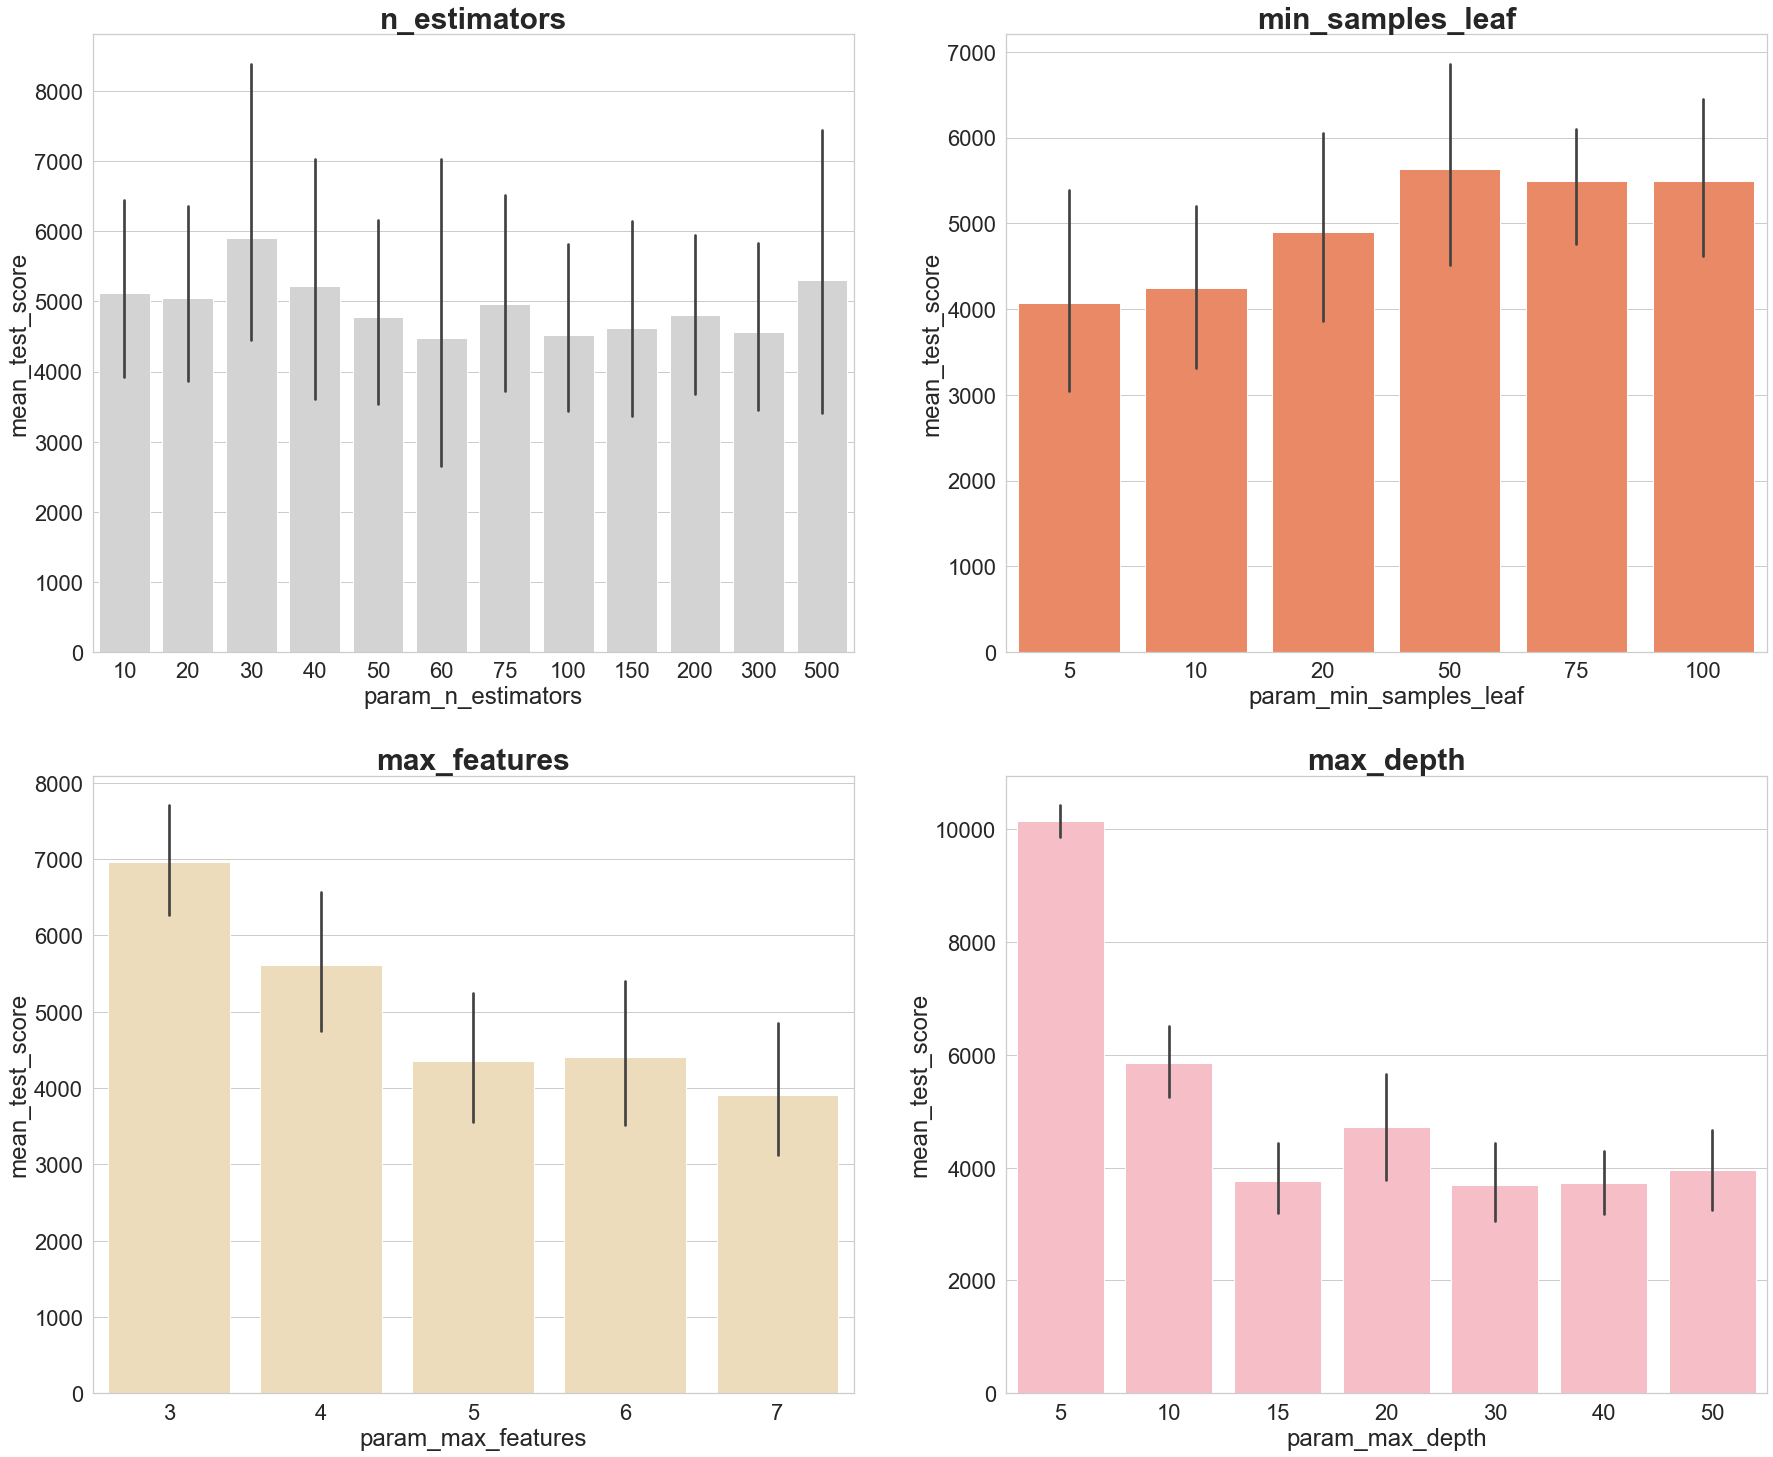

In [112]:
fig, axs = plt.subplots(ncols=2, nrows=2) 
sns.set(style="whitegrid", color_codes=True, font_scale = 2) 
fig.set_size_inches(30,25)
sns.barplot(x='param_n_estimators', y='mean_test_score', data=rf_rand_df, 
            ax=axs[0,0], color='lightgrey') 
axs[0,0].set_title(label = 'n_estimators', size=30, weight='bold')

sns.barplot(x='param_min_samples_leaf', y='mean_test_score', data=rf_rand_df, 
            ax=axs[0,1], color='coral')
axs[0,1].set_title(label = 'min_samples_leaf', size=30, weight='bold')

sns.barplot(x='param_max_features', y='mean_test_score', data=rf_rand_df, 
            ax=axs[1,0], color='wheat')
axs[1,0].set_title(label = 'max_features', size=30, weight='bold')

sns.barplot(x='param_max_depth', y='mean_test_score', data=rf_rand_df, 
            ax=axs[1,1], color='lightpink') 
axs[1,1].set_title(label = 'max_depth', size=30, weight='bold')

#### Random Search for xgboost regressor

In [ ]:
params_XGB_rand = {'n_estimators': [10,20,50,75,100,150,200,250,300,400,500],
         'max_depth': [5,10,15,20,25,30,40,50,60],
         'learning_rate' :[0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5],
         'colsample_bytree':[0.5, 0.6, 0.7, 0.8, 0.9, 1]}

XGB_rand = xgb.XGBRegressor(objective='reg:squarederror')
grid_XGB_rand = RandomizedSearchCV(XGB_rand,params_XGB_rand, n_iter=120,
                                   cv=3,scoring =my_scorer,n_jobs=-1 )
grid_XGB_rand.fit(X,y)

print(grid_XGB_rand.best_score_)
print(grid_XGB_rand.best_params_)

In [ ]:
# result of random search for xgboost
# -1250.7769346917173
# {'n_estimators': 400, 'max_depth': 15, 'learning_rate': 0.1, 'colsample_bytree': 0.9}

In [84]:
xgb_rand_df = pd.DataFrame(grid_XGB_rand.cv_results_).sort_values('rank_test_score').reset_index(drop=True) 
xgb_rand_df = xgb_rand_df.drop([ 'mean_fit_time',  'std_fit_time',  
                    'mean_score_time', 'std_score_time',  'params',  
                    'split0_test_score',  'split1_test_score',  'split2_test_score',  
                    'std_test_score'], axis=1) 

xgb_rand_df = xgb_rand_df.dropna(axis = 0,how = 'any')
xgb_rand_df['mean_test_score'] = -xgb_rand_df['mean_test_score']

In [104]:
xgb_rand_df

,param_n_estimators,param_max_depth,param_learning_rate,param_colsample_bytree,mean_test_score,rank_test_score
0,400,15,0.1,0.9,1250.776935,1
1,200,15,0.15,0.9,1269.121967,2
2,200,15,0.15,0.7,1302.351007,3
3,400,10,0.2,1,1315.700859,4
4,100,20,0.3,0.7,1342.151469,5
...,...,...,...,...,...,...
65,20,20,0.1,0.5,6445.355345,66
66,20,5,0.15,0.7,7703.425087,67
67,10,5,0.2,0.9,7759.669488,68
68,10,10,0.1,0.7,9091.270416,69


In [ ]:
xgb_rand_df.to_csv('xgb_randsearch.csv',index = False)

Text(0.5, 1.0, 'max_depth')

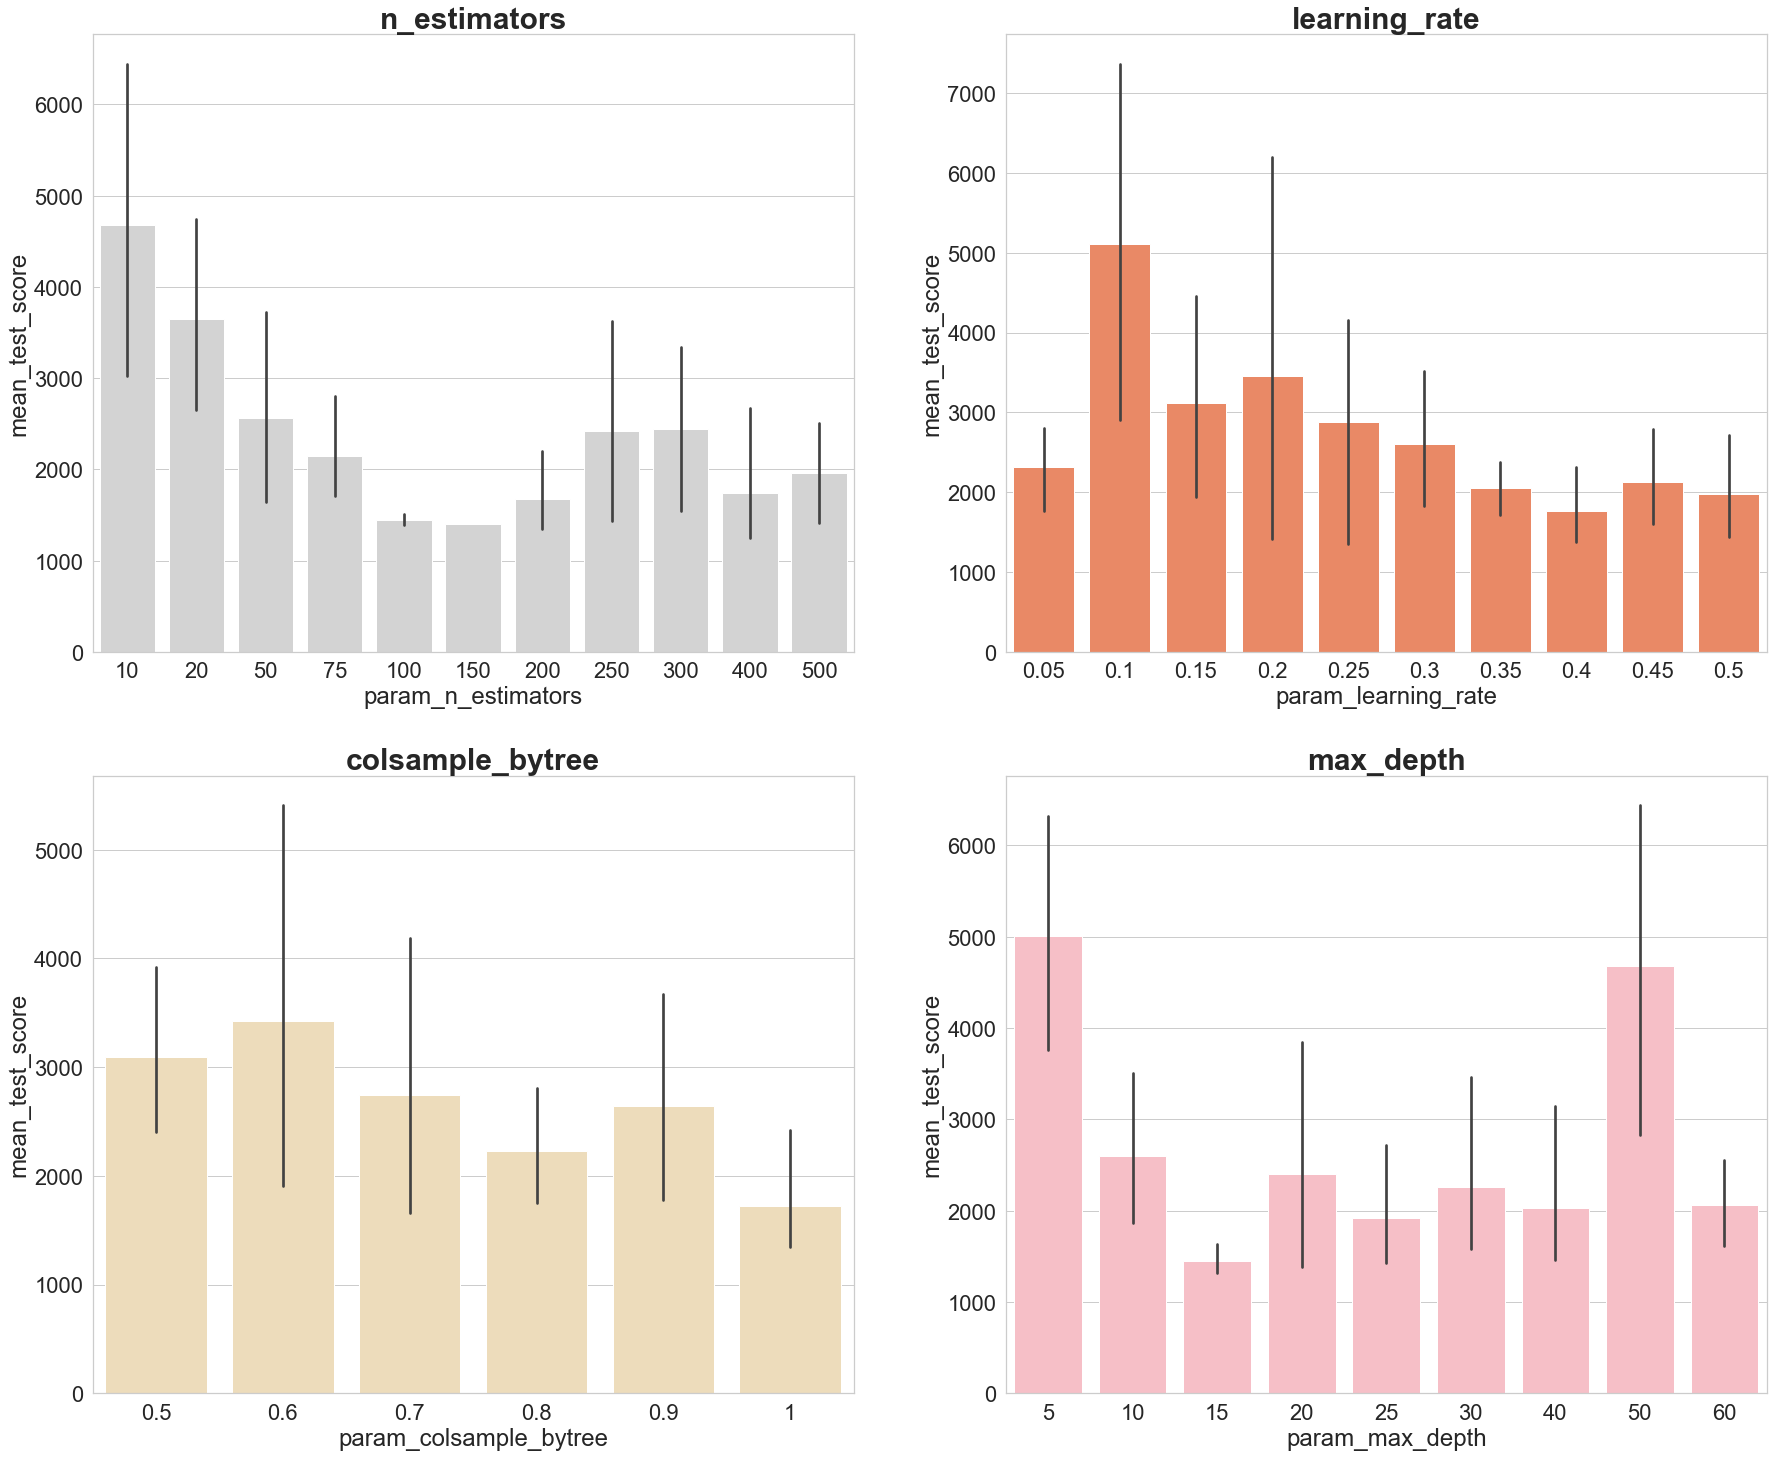

In [105]:
fig, axs = plt.subplots(ncols=2, nrows=2) 
sns.set(style="whitegrid", color_codes=True, font_scale = 2) 
fig.set_size_inches(30,25)
sns.barplot(x='param_n_estimators', y='mean_test_score', data=xgb_rand_df, 
            ax=axs[0,0], color='lightgrey') 
axs[0,0].set_title(label = 'n_estimators', size=30, weight='bold')

sns.barplot(x='param_learning_rate', y='mean_test_score', data=xgb_rand_df, 
            ax=axs[0,1], color='coral') 
axs[0,1].set_title(label = 'learning_rate', size=30, weight='bold')

sns.barplot(x='param_colsample_bytree', y='mean_test_score', data=xgb_rand_df, 
            ax=axs[1,0], color='wheat') 
axs[1,0].set_title(label = 'colsample_bytree', size=30, weight='bold')

sns.barplot(x='param_max_depth', y='mean_test_score', data=xgb_rand_df, 
            ax=axs[1,1], color='lightpink') 
axs[1,1].set_title(label = 'max_depth', size=30, weight='bold')

#### GridSearchCV for random forest regressor

##### Round1

In [20]:
# {'n_estimators': 300, 'min_samples_leaf': 5, 'max_features': 7, 'max_depth': 50}

params = {'n_estimators': [50,60,100,150,200,300,350],
          'min_samples_leaf':[2,5,10,15],
         'max_features': [5,6,7],
         'max_depth':[15,30,40,50]}

RF = RandomForestRegressor()
grid = GridSearchCV(RF,params,cv=3, scoring =my_scorer,n_jobs=-1 )
grid.fit(X,y)

print(grid.best_score_)
print(grid.best_params_)

-1599.968103686363
{'max_depth': 30, 'max_features': 7, 'min_samples_leaf': 2, 'n_estimators': 350}


In [21]:
rf_grid_df = pd.DataFrame(grid.cv_results_).sort_values('rank_test_score').reset_index(drop=True) 
rf_grid_df = rf_grid_df.drop([ 'mean_fit_time',  'std_fit_time',  
                    'mean_score_time', 'std_score_time',  'params',  
                    'split0_test_score',  'split1_test_score',  'split2_test_score',  
                    'std_test_score'], axis=1) 
rf_grid_df['mean_test_score'] = -rf_grid_df['mean_test_score']
rf_grid_df

,param_max_depth,param_max_features,param_min_samples_leaf,param_n_estimators,mean_test_score,rank_test_score
0,30,7,2,350,1599.968104,1
1,50,7,2,350,1600.675718,2
2,40,7,2,350,1600.698529,3
3,30,7,2,300,1600.761801,4
4,40,7,2,300,1600.974415,5
...,...,...,...,...,...,...
331,15,5,15,300,3306.911012,332
332,15,5,15,50,3311.062542,333
333,15,5,15,350,3313.162307,334
334,15,5,15,60,3319.286883,335


Text(0.5, 1.0, 'max_depth')

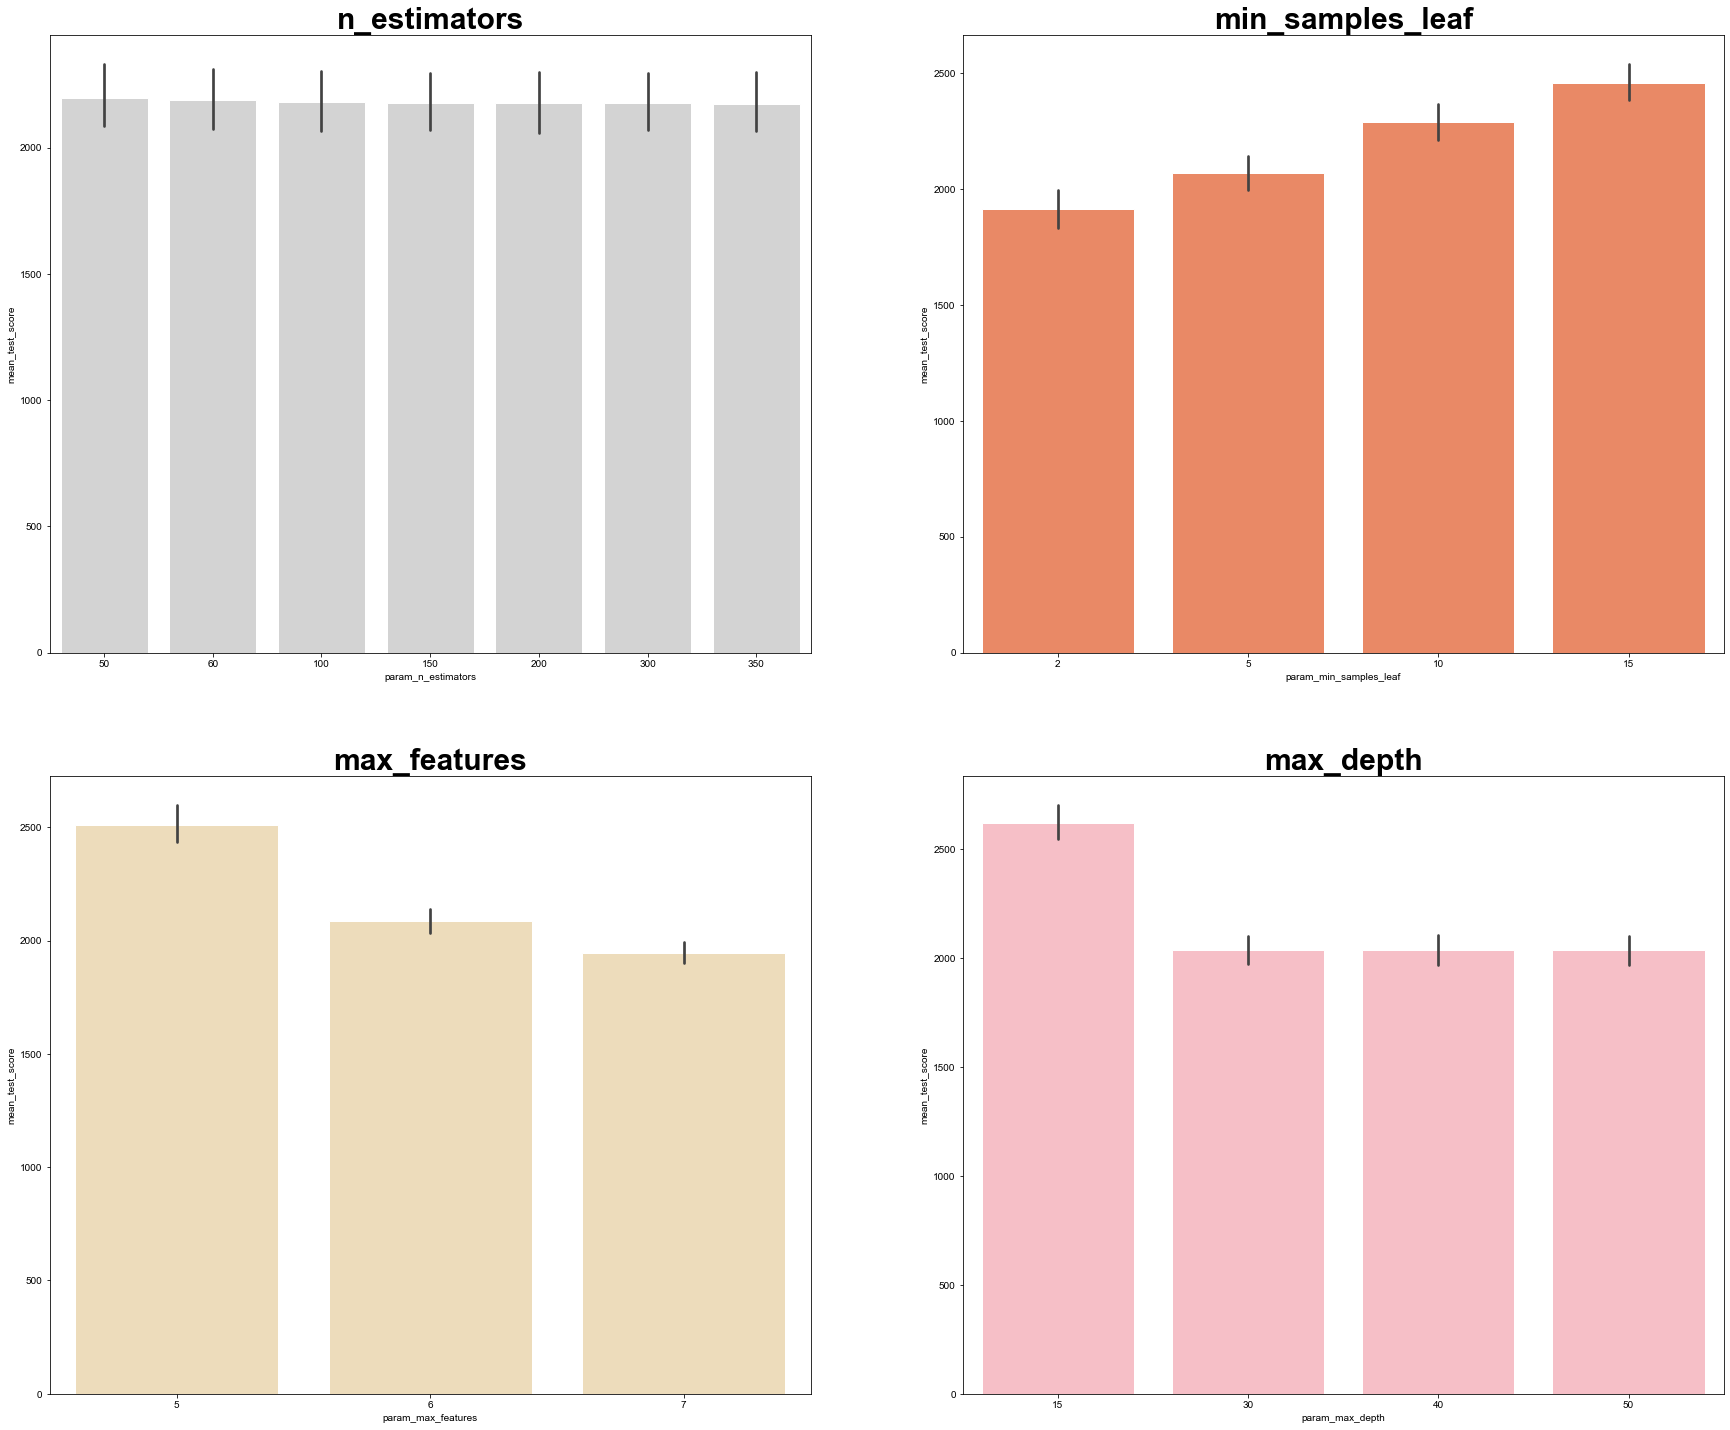

In [22]:
fig, axs = plt.subplots(ncols=2, nrows=2) 
sns.set(style="whitegrid", color_codes=True, font_scale = 2) 
fig.set_size_inches(30,25)
sns.barplot(x='param_n_estimators', y='mean_test_score', data=rf_grid_df, 
            ax=axs[0,0], color='lightgrey') 
axs[0,0].set_title(label = 'n_estimators', size=30, weight='bold')

sns.barplot(x='param_min_samples_leaf', y='mean_test_score', data=rf_grid_df, 
            ax=axs[0,1], color='coral')
axs[0,1].set_title(label = 'min_samples_leaf', size=30, weight='bold')

sns.barplot(x='param_max_features', y='mean_test_score', data=rf_grid_df, 
            ax=axs[1,0], color='wheat')
axs[1,0].set_title(label = 'max_features', size=30, weight='bold')

sns.barplot(x='param_max_depth', y='mean_test_score', data=rf_grid_df, 
            ax=axs[1,1], color='lightpink') 
axs[1,1].set_title(label = 'max_depth', size=30, weight='bold')

##### Round2

In [ ]:
params_2 = {'n_estimators': [60,200,300,350],
         'max_features': [7],
         'min_samples_leaf':[1,2],
         'max_depth':[30,40,50]}

RF_2 = RandomForestRegressor()
grid_2 = GridSearchCV(RF_2,params_2,cv=3, scoring =my_scorer,n_jobs=-1 )
grid_2.fit(X,y)

print(grid_2.best_score_)
print(grid_2.best_params_)

In [ ]:
rf_grid_df_2 = pd.DataFrame(grid_2.cv_results_).sort_values('rank_test_score').reset_index(drop=True) 
rf_grid_df_2 = rf_grid_df_2.drop([ 'mean_fit_time',  'std_fit_time',  
                    'mean_score_time', 'std_score_time',  'params',  
                    'split0_test_score',  'split1_test_score',  'split2_test_score',  
                    'std_test_score'], axis=1) 
rf_grid_df_2['mean_test_score'] = -rf_grid_df_2['mean_test_score']
rf_grid_df_2

In [ ]:
rf_grid_df_2.to_csv('rf_grid2.1.csv',index = False)

In [ ]:
# results of gridsearch for random forest regressor
# -1557.4551819135522
# {'max_depth': 40, 'max_features': 7, 'min_samples_leaf': 1, 'n_estimators': 300}

#### GridSearchCV for xgboost regressor

In [ ]:
# {'n_estimators': 400, 'max_depth': 15, 'learning_rate': 0.1, 'colsample_bytree': 0.9}

# params_grid_XGB = {'n_estimators': [100,150],
#          'max_depth': [15,25],
#          'learning_rate': [0.35,0.4]}

# XGB = xgb.XGBRegressor(objective='reg:squarederror')
# grid_XGB = RandomizedSearchCV(XGB,params_grid_XGB, cv=3, scoring =my_scorer,n_iter=8,n_jobs=-1)
# grid_XGB.fit(X,y)

# print(grid_XGB.best_score_)
# print(grid_XGB.best_params_)

In [ ]:
# xgb_grid_df = pd.DataFrame(grid_XGB.cv_results_).sort_values('rank_test_score').reset_index(drop=True) 
# xgb_grid_df = xgb_grid_df.drop([ 'mean_fit_time',  'std_fit_time',  
#                     'mean_score_time', 'std_score_time',  'params',  
#                     'split0_test_score',  'split1_test_score',  'split2_test_score',  
#                     'std_test_score'], axis=1) 
# xgb_grid_df['mean_test_score'] = -xgb_grid_df['mean_test_score']
# xgb_grid_df

In [ ]:
# xgb_grid_df.to_csv('xgb_grid.csv',index = False)

In [28]:
def xgb_k_fold_cv(k,X,y,n_estimators,max_depth,learning_rate):
    kf = KFold(n_splits=k) 
    
    xgb_wmae = []
    
    for train_index, val_index in kf.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        xgb_regr = xgb.XGBRegressor(objective='reg:squarederror',n_estimators = n_estimators, 
                            max_depth = max_depth, learning_rate = learning_rate)
        xgb_regr.fit(X_train, y_train)
        xgb_pred = xgb_regr.predict(X_val)
        
        xgb_wmae.append(wmae(X_val,y_val,xgb_pred))
        
    return {'n_estimators': n_estimators, 
            'max_depth':max_depth, 
            'learning_rate':learning_rate, 
            'mean_test_score': np.mean(xgb_wmae)}
         

In [16]:
n_estimators_lst =  [100]
max_depth_lst = [15]
learning_rate_lst = [0.35,0.4]

temp = []

for n_estimators in n_estimators_lst:
    for max_depth in max_depth_lst:
        for learning_rate in learning_rate_lst:
            temp.append(xgb_k_fold_cv(3,X,y,n_estimators,max_depth,learning_rate))

xgb_grid_df = pd.DataFrame(temp)

In [17]:
xgb_grid_df

,n_estimators,max_depth,learning_rate,mean_test_score
0,100,15,0.35,1330.269334
1,100,15,0.40,1351.305201


In [19]:
n_estimators_lst =  [150]
max_depth_lst = [15]
learning_rate_lst = [0.35,0.4]

temp3 = []

for n_estimators in n_estimators_lst:
    for max_depth in max_depth_lst:
        for learning_rate in learning_rate_lst:
            temp3.append(xgb_k_fold_cv(3,X,y,n_estimators,max_depth,learning_rate))

xgb_grid_df3 = pd.DataFrame(temp3)
xgb_grid_df3

,n_estimators,max_depth,learning_rate,mean_test_score
0,150,15,0.35,1335.370948
1,150,15,0.40,1357.084322


In [29]:
n_estimators_lst =  [100,150]
max_depth_lst = [15]
learning_rate_lst = [0.1,0.15]

temp4 = []

for n_estimators in n_estimators_lst:
    for max_depth in max_depth_lst:
        for learning_rate in learning_rate_lst:
            temp4.append(xgb_k_fold_cv(3,X,y,n_estimators,max_depth,learning_rate))

xgb_grid_df4 = pd.DataFrame(temp4)
xgb_grid_df4

,n_estimators,max_depth,learning_rate,mean_test_score
0,100,15,0.10,1320.534716
1,100,15,0.15,1293.570671
2,150,15,0.10,1288.775768
3,150,15,0.15,1274.059535


In [37]:
frames = [xgb_grid_df, xgb_grid_df3,xgb_grid_df4]
xgb_grid_res = pd.concat(frames)
xgb_grid_res = xgb_grid_res.sort_values('mean_test_score').reset_index(drop=True) 
xgb_grid_res

,n_estimators,max_depth,learning_rate,mean_test_score
0,150,15,0.15,1274.059535
1,150,15,0.10,1288.775768
2,100,15,0.15,1293.570671
3,100,15,0.10,1320.534716
4,100,15,0.35,1330.269334
5,150,15,0.35,1335.370948
6,100,15,0.40,1351.305201
7,150,15,0.40,1357.084322


### Test

#### random forest regressor

In [24]:
# {'max_depth': 30, 'max_features': 7, 'min_samples_leaf': 2, 'n_estimators': 350}
# {'max_depth': 40, 'max_features': 7, 'min_samples_leaf': 1, 'n_estimators': 300}
rf_regr = RandomForestRegressor(n_estimators = 300, max_depth=40, 
                                max_features = 7,min_samples_leaf = 1)
rf_regr.fit(X,y)

RandomForestRegressor(max_depth=50, max_features=7, n_estimators=200)

In [43]:
# (round 1)
# {'max_depth': 30, 'max_features': 7, 'min_samples_leaf': 2, 'n_estimators': 350} 2889 2819 
# {'max_depth': 30, 'max_features': 7, 'min_samples_leaf': 1, 'n_estimators': 350} 2852 2759
# {'max_depth': 50, 'max_features': 7, 'min_samples_leaf': 2, 'n_estimators': 350} 2892 2812 

#（round 2）
# {'max_depth': 40, 'max_features': 7, 'min_samples_leaf': 1, 'n_estimators': 300} 2852 2760 
# {'max_depth': 40, 'max_features': 7, 'min_samples_leaf': 1, 'n_estimators': 200} 2856 2764


In [26]:
X_test = pd.read_csv('preprocessed_test.csv')
rf_test = X_test.copy()

rf_pred = rf_regr.predict(rf_test.drop('Date',axis = 1))
rf_test['Weekly_Sales'] = rf_pred

rf_test['Id'] = rf_test['Store'].astype(str) + '_'+ rf_test['Dept'].astype(str) + '_' +  rf_test['Date'].astype(str)

rf_res = rf_test[['Id','Weekly_Sales']]
rf_res.to_csv('submission_rf.csv',index = False)

#### xgboost regressor test

In [44]:
# {'n_estimators': 400, 'max_depth': 15, 'learning_rate': 0.1, 'colsample_bytree': 0.9}
xgb_regr = xgb.XGBRegressor(objective='reg:squarederror',n_estimators = 100, 
                            max_depth = 15, learning_rate = 0.1,colsample_bytree = 1)
xgb_regr.fit(X,y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=15,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=16, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [45]:
X_test = pd.read_csv('preprocessed_test.csv')
xgb_test = X_test.copy()

xgb_pred = xgb_regr.predict(xgb_test.drop('Date',axis = 1))
xgb_test['Weekly_Sales'] = xgb_pred

xgb_test['Id'] = xgb_test['Store'].astype(str) + '_'+ xgb_test['Dept'].astype(str) + '_' +  xgb_test['Date'].astype(str)

xgb_res = xgb_test[['Id','Weekly_Sales']]
xgb_res.to_csv('submission_xgb.csv',index = False)

In [ ]:
# Randomized search top 5 models
# {'n_estimators': 400, 'max_depth': 15, 'learning_rate': 0.1, 'colsample_bytree': 0.9}  2912 2814
# {'n_estimators': 200, 'max_depth': 15, 'learning_rate': 0.15, 'colsample_bytree': 0.9}  2909 2818
# {'n_estimators': 200, 'max_depth': 15, 'learning_rate': 0.15, 'colsample_bytree': 0.7}  2893 2794
# {'n_estimators': 400, 'max_depth': 10, 'learning_rate': 0.2, 'colsample_bytree': 1} 2910 2816
# {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.3, 'colsample_bytree': 0.7} 2942 2853

# Grid search top 3 models
# {'n_estimators': 150, 'max_depth': 15, 'learning_rate': 0.15, 'colsample_bytree': 1} 2880 2783
# {'n_estimators': 150, 'max_depth': 15, 'learning_rate': 0.1, 'colsample_bytree': 1} 2879 2783
# {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.1, 'colsample_bytree': 1} 2886 2790